In [1]:
import sys

sys.path.append('.')

import model

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statistics

In [3]:
N = 100
K = 4
p_star = 0.256

g, _ = model.watts_strogatz_case_p_star(N, K, p_star)

green_cmap = plt.get_cmap('Greens')
orange_cmap = plt.get_cmap('Oranges')

plt.figure(3,figsize=(7,7)) 
nx.draw_circular(g,
                 node_size = 15,
                 node_color = ['c' if latitude(x) > 0 else 'b' for x in g.nodes()],
                 edge_color = ['c' 
                               if latitude(e[0]) > 0 and latitude(e[1]) > 0
                               else 'k' for e in g.edges()]
                )

NameError: name 'latitude' is not defined

<Figure size 504x504 with 0 Axes>

We suspect that contact tracing is more effective when its adoption is _dense_.

Let's consider a Watts-Strogatzz graph as before.

In [4]:
N = 2000
K = 4
p_star = 0.256

In [5]:
def ws_case_generator(N, K, p_star):
    def wscg(**kwargs):
        return model.watts_strogatz_case_p_star(N, K, p_star, **kwargs)
    
    return wscg

In [5]:
g, _ = model.watts_strogatz_case_p_star(N, K, p_star)

But this time we will segment the population into two regional halves, a 'north' and a 'south'.

In [29]:
def latitude(i):
    dist_from_north_pole = min(
        i, 
        abs(N / 4 - i) # 1/4 here is just rotating, for the drawing
    )
    return N / 4 - dist_from_north_pole

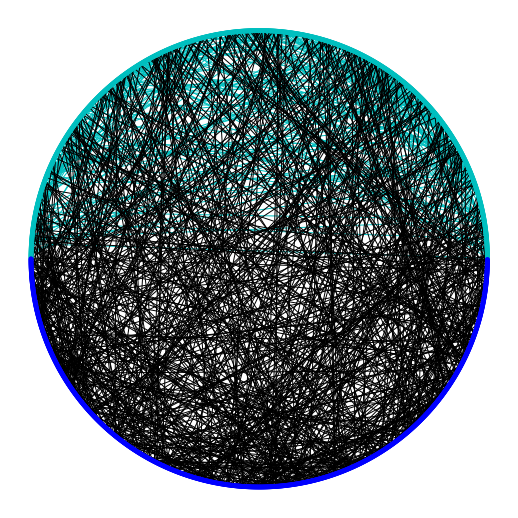

In [7]:
green_cmap = plt.get_cmap('Greens')
orange_cmap = plt.get_cmap('Oranges')

plt.figure(3,figsize=(7,7)) 
nx.draw_circular(g,
                 node_size = 15,
                 node_color = ['c' if latitude(x) > 0 else 'b' for x in g.nodes()],
                 edge_color = ['c' 
                               if latitude(e[0]) > 0 and latitude(e[1]) > 0
                               else 'k' for e in g.edges()]
                )

We can compute the expected value of inter-group edges, and compare them with the empirical values.

This is the computed number of north-north edges.

In [8]:
len(g.edges())

4000

In [32]:
both_north = [
    e
    for e in g.edges()
    if latitude(e[0]) > 0 and latitude(e[1]) > 0
]

len(both_north)

83

We would expect that as function of $N$, $k$, and $p$, this value to be:
 - The chance of the first node being in the northern hemisphere, $1/2$, times
 - The chance that the linked node is in the northern hemisphere, which is, approximately:
   - $(1 - p)$, for the chance that the edge is "close" and therefore another "north" node
     - this will be offer by a small amount, proportional to $K / N$, due to "border nodes"
   - $p / 2$, for the chance that the edge is "distant" and the (randomly chosen) distant edge is also in the "north"
   
Or, in total, $(NK/2) * 1/2 * ((1 - p) + p / 2)$ north-north edges.

In [10]:
(N * K / 2) * .5 * ((1 - p_star) + p_star / 2)

1744.0

Which we see is indeed very close to an "empirical" value based on randomized distant links.

An elaboration of this would allow for regional partitions of the node space beyond half-half.

-------------------------------

Tying this back to contact tracing, we can consider what happens when the geographic regions (which might represent of forms of social categorization or partitioning) have different adoption rates.

This difference in adoption could be due to group or activity based privacy concerns, such as those having to do with being an ethnic minority or attending political demonstrations.

In the most extreme cases, the adoption rate of the first group is $A_0 = 1$ and the adoption rate of the second group is $A_1 = 0$.

In this case, the number of "traced edges" is equal to the number of "north-north" edges.
This is a function of $p$ but, notably, we are treating traced edges that are "close" and "distant" as the same.

In general, if $b$ is the proportion of nodes in the first group, then the number of traced edges will be equal to:

- The chance of being a north-north edge, $b * (1 - (1 - b)p)$ times the north-north tracing rate $A_0^2$
- The chance of being a south-south edge, $(1 - b) * (1 - b p)$ times the south-south tracing rate $A_1^2$
- The chance of being a north-south or south-north edge $b * p * (1 - b) + (1 - b) * p * b = 2pb(1-b)$ times the north-south tracing rate $A_0 A_1$


If $b = 0.5$, then these come to 
$$(.5 - .25p) * A_0^2 + (.5 - .25p) * A_1^2 + 2pb(1-b) * A_0 A_1$$
$$(.5 - .25p) * A_0^2 + (.5 - .25p) * A_1^2 + .5p * A_0 A_1$$

Let $A_0 = \mu - \delta$ and $A_1 = \mu + \delta$

Then total number of traced edges is:

$$(.5 - .25p) (\mu - \delta)^2 + (.5 - .25p) (\mu + \delta)^2 + .5p (\mu - \delta) (\mu + \delta)$$

$$(.5 - .25p) * (\mu^2 - 2 \mu \delta + \delta^2) + (.5 - .25p) * (\mu^2 + 2 \mu \delta + \delta^2 ) + .5p * (\mu^2 - \delta^2)$$

$$(1 - .5p) * (\mu^2 + \delta^2 ) +  .5p * (\mu^2 - \delta^2)$$

$$\mu^2 + \delta^2 - .5p (\mu^2 + \delta^2)  +  .5p (\mu^2 - \delta^2)$$

$$\mu^2 + \delta^2 - p \delta^2 = T$$

----------------------------------------------------------------

One question we might ask is whether, for a given number of traced edges, whether it matters how much they are grouped together.

We can operationalize this like so:
 - Given the _subgraph_ $G_T$ of $G$ which includes nodes with traced edges
 - and the _local clustering coefficient_ of each node in this subgraph (how close its neighbors are to being a clique, i.e. fully connected)
 - what is the _average local clustering coefficient_ of $G_T$. (This is the version of 'clustering coefficient' developed by Watts and Strogatz in the construction of the Watts-Strogatz model.)

We can run the numbers with the simple case that $A_0 = 1$ and $A_1 = 1$ below.

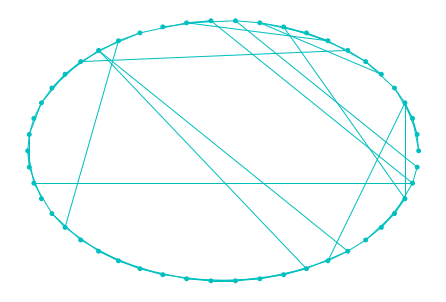

In [33]:
traced_nodes = set([x[0] for x in both_north]).union(set([x[1] for x in both_north]))

gt = g.subgraph(traced_nodes)

nx.draw_circular(gt,
                 node_size = 15,
                 node_color = ['c' if latitude(x) > 0 else 'b' for x in gt.nodes()],
                 edge_color = ['c' 
                               if latitude(e[0]) > 0 and latitude(e[1]) > 0
                               else 'k' for e in gt.edges()]
                )

In [14]:
nx.average_clustering(gt)

0.28926424277125684

---------------------------------------------------------------

In [15]:
N = 2000
K = 4
p_star = 0.256

In [16]:
## Population parameters:
base_params = {
    # Node parameter
    'A' : 1, # This will be modified in each case 
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0, ## all edges can be traced.
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [17]:
conditions = {
    'mu-0.4_d-0.0' : {'A' : model.hemisphere_adoption(0.4, 0.0), 'mu' : 0.4, 'delta' : 0.0},
    'mu-0.4_d-0.1' : {'A' : model.hemisphere_adoption(0.4, 0.1), 'mu' : 0.4, 'delta' : 0.1},
    'mu-0.4_d-0.2' : {'A' : model.hemisphere_adoption(0.4, 0.0), 'mu' : 0.4, 'delta' : 0.2},
    'mu-0.4_d-0.3' : {'A' : model.hemisphere_adoption(0.4, 0.0), 'mu' : 0.4, 'delta' : 0.3},
    'mu-0.4_d-0.4' : {'A' : model.hemisphere_adoption(0.4, 0.0), 'mu' : 0.4, 'delta' : 0.4},
    'mu-0.5_d-0.0' : {'A' : model.hemisphere_adoption(0.5, 0.0), 'mu' : 0.5, 'delta' : 0.0},
    'mu-0.5_d-0.05' : {'A' : model.hemisphere_adoption(0.5, 0.1), 'mu' : 0.5, 'delta' : 0.05},
    'mu-0.5_d-0.1' : {'A' : model.hemisphere_adoption(0.5, 0.1), 'mu' : 0.5, 'delta' : 0.1},
    'mu-0.5_d-0.15' : {'A' : model.hemisphere_adoption(0.5, 0.1), 'mu' : 0.5, 'delta' : 0.15},
    'mu-0.5_d-0.2' : {'A' : model.hemisphere_adoption(0.5, 0.2), 'mu' : 0.5, 'delta' : 0.2},
    'mu-0.5_d-0.25' : {'A' : model.hemisphere_adoption(0.5, 0.1), 'mu' : 0.5, 'delta' : 0.25},
    'mu-0.5_d-0.3' : {'A' : model.hemisphere_adoption(0.5, 0.3), 'mu' : 0.5, 'delta' : 0.3},
    'mu-0.5_d-0.35' : {'A' : model.hemisphere_adoption(0.5, 0.1), 'mu' : 0.5, 'delta' : 0.35},
    'mu-0.5_d-0.4' : {'A' : model.hemisphere_adoption(0.5, 0.4), 'mu' : 0.5, 'delta' : 0.4},
    'mu-0.5_d-0.45' : {'A' : model.hemisphere_adoption(0.5, 0.1), 'mu' : 0.5, 'delta' : 0.45},
    'mu-0.5_d-0.5' : {'A' : model.hemisphere_adoption(0.5, 0.5), 'mu' : 0.5, 'delta' : 0.5},
    'mu-0.7_d-0.0' : {'A' : model.hemisphere_adoption(0.7, 0.0), 'mu' : 0.7, 'delta' : 0.0},
    'mu-0.7_d-0.15' : {'A' : model.hemisphere_adoption(0.7, 0.15), 'mu' : 0.7, 'delta' : 0.15},
    'mu-0.7_d-0.3' : {'A' : model.hemisphere_adoption(0.7, 0.3), 'mu' : 0.7, 'delta' : 0.3}
}

In [18]:
def dfr(rs):
    return pd.DataFrame(
        [r for case in rs 
         for r in model.data_from_results(rs, case)])

runs = 200
base_params['A'] = 1

rs = model.experiment(
    ws_case_generator(N, K, p_star),
    base_params,
    conditions,
    runs)

temp = dfr(rs)
temp.to_csv('hemisphere_study.csv')
#del rs

Starting mu-0.4_d-0.0
Initializing input graphs
graphs prepared in 6.655825305999315
Finished mu-0.4_d-0.0 in 433.120028379999
Starting mu-0.4_d-0.1
Initializing input graphs
graphs prepared in 6.681943144998513
Finished mu-0.4_d-0.1 in 448.20894766600395
Starting mu-0.4_d-0.2
Initializing input graphs
graphs prepared in 6.6649800119994325
Finished mu-0.4_d-0.2 in 389.9540021970024
Starting mu-0.4_d-0.3
Initializing input graphs
graphs prepared in 6.369069847998617
Finished mu-0.4_d-0.3 in 374.74321630300255
Starting mu-0.4_d-0.4
Initializing input graphs
graphs prepared in 6.915729207001277
Finished mu-0.4_d-0.4 in 370.7502112939983
Starting mu-0.5_d-0.0
Initializing input graphs
graphs prepared in 6.572464692995709
Finished mu-0.5_d-0.0 in 361.45825729399803
Starting mu-0.5_d-0.05
Initializing input graphs
graphs prepared in 6.494130106999364
Finished mu-0.5_d-0.05 in 369.57286210500024
Starting mu-0.5_d-0.1
Initializing input graphs
graphs prepared in 6.567685744994378
Finished mu-0

-----------------------------------

#### Analysis

This is the analysis section

In [6]:
data = pd.read_csv('hemisphere_study.csv')

In [7]:
data['traced_edges_close'] = data['traced_edges'] - data['traced_edges_distant']
data['traced_edges_ratio'] = data['traced_edges'] / (data['N'] * data['K'] / 2)
data['traced_edges_distant_ratio'] = data['traced_edges_distant'] / data['traced_edges']

data['T'] = data['mu'] ** 2 + data['delta'] ** 2 - data['p'] * data['delta'] ** 2
data['d/mu'] = data['delta'] / data['mu']

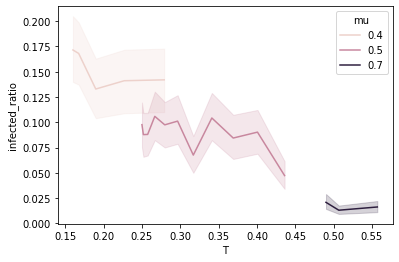

In [8]:
data["delta-cat"] = data["delta"].apply(lambda x: f"delta = {x}")

splot = sns.lineplot(x='T', y='infected_ratio', hue="mu", data=data)

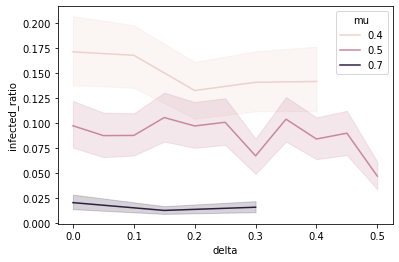

In [9]:
data["delta-cat"] = data["delta"].apply(lambda x: f"delta = {x}")

splot = sns.lineplot(x='delta', y='infected_ratio', hue="mu", data=data)

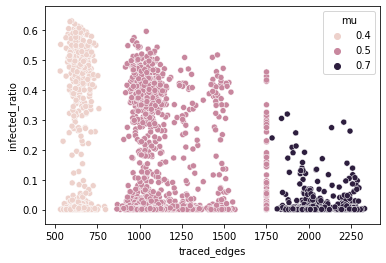

In [14]:
g = sns.scatterplot(
    data = data,
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = "mu"
)

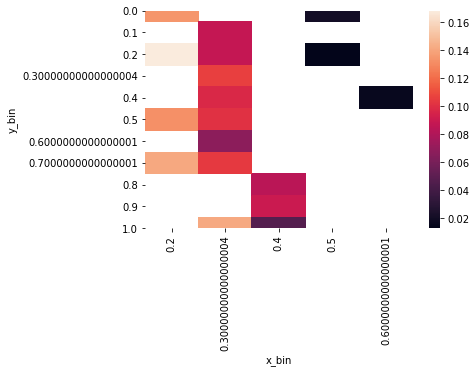

In [15]:
g, xyz, db = model.binned_heatmap(
    data,
    x = 'T',
    x_base = 0.1,
    y = 'd/mu',
    y_base = .1,
    z = 'infected_ratio'
)

In [16]:
extreme = data[data["mu"] == 0.5]

extreme = data[data["delta"] == 0.5]

(array([150.,   8.,   2.,   5.,   1.,   3.,   1.,   1.,   0.,   4.,   1.,
          2.,   2.,   0.,   2.,   0.,   1.,   2.,   4.,   2.,   2.,   1.,
          1.,   0.,   0.,   0.,   0.,   2.,   1.,   2.]),
 array([0.0005 , 0.01585, 0.0312 , 0.04655, 0.0619 , 0.07725, 0.0926 ,
        0.10795, 0.1233 , 0.13865, 0.154  , 0.16935, 0.1847 , 0.20005,
        0.2154 , 0.23075, 0.2461 , 0.26145, 0.2768 , 0.29215, 0.3075 ,
        0.32285, 0.3382 , 0.35355, 0.3689 , 0.38425, 0.3996 , 0.41495,
        0.4303 , 0.44565, 0.461  ]),
 <a list of 30 Patch objects>)

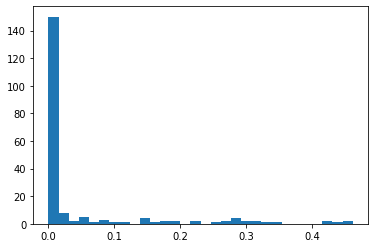

In [22]:
plt.hist(extreme['infected_ratio'],bins=30)

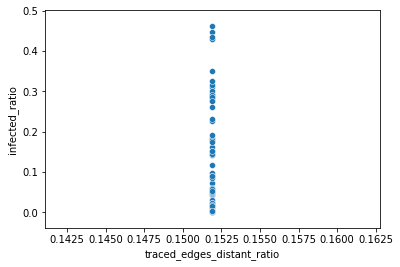

In [27]:
g = sns.scatterplot(
    data = extreme,
    y = 'infected_ratio',
    x = 'traced_edges_distant_ratio',
)